In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from scipy.stats import sem
import h5py
from pathlib import Path
from collections.abc import Iterable

In [2]:
datapath = Path.cwd() / "data"
figurepath = Path.cwd().parent / "figures"

In [3]:
W = 5.88    # Figure width in inches, approximately A4-width - 2*1.25in margin
plt.rcParams.update({
    'figure.figsize': (W, W),#/(4/3)),     # 1:1 aspect ratio
    'font.size' : 11,                   # Set font size to 11pt
    'axes.labelsize': 11,               # -> axis labels
    'legend.fontsize': 10,              # -> legends
    'font.family': 'lmodern',
    'text.usetex': True,
    'text.latex.preamble': (            # LaTeX preamble
        r'\usepackage{lmodern}'
        # ... more packages if needed
    )
})

In [4]:
def set_size(width='thesis', fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    aspect_ratio = 1#(5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * aspect_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)


In [5]:
def rearrange_data(arr): #
    res = np.swapaxes(arr,-1,0)
    res = np.swapaxes(res,-2,1)
    return res

def disorder_mean(A, n_samples = None):
    if n_samples is None:
        return np.mean(A,2)
    else:
        return np.mean(A[:,:,0:n_samples],2)

def disorder_std(A, n_samples = None):
    if n_samples is None:
        return np.std(A,2,ddof=1)
    else:
        return np.std(A[:,:,0:n_samples],2,ddof=1)
def disorder_sem(A, n_samples = None):
    if n_samples is None:
        return sem(A,axis=2)
    else:
        return sem(A[:,:,0:n_samples],axis=2)

In [6]:
def idx_transgression(arr,threshold):
    idx = np.zeros(arr.shape[1],dtype=int)
    for j in range(arr.shape[1]):
        found = False
        for i in range(arr.shape[0]):
            if found == False and arr[i,j] >= threshold:
                idx[j] = i
                found = True
        if found == False:
            idx[j] = -1 #be careful that this never breaks things
    return idx

def safeguard_minusone(idx):
    res = np.zeros(idx.shape[0],dtype=float)
    for i in range(idx.shape[0]):
        res[i] = idx[i] if idx[i] != -1 else np.nan
    return res

def mask_transgression(arr,threshold):
    mask = np.zeros(arr.shape,dtype=bool)
    idx = idx_transgression(arr,threshold)
    for j in range(arr.shape[1]):
        if idx[j] != -1:
            mask[idx[j],j]=True
    return mask

def T_transgression(T,arr,threshold):
    idx = idx_transgression(arr,threshold)
    t_past = T[idx]
    t_before = T[[i-1 if i > 0 else 0 for i in idx]]
    arr_past = np.zeros(arr.shape[1])
    arr_before = np.zeros(arr.shape[1])
    t_th = np.zeros(arr.shape[1])
    for j in range(0,arr.shape[1]):
        arr_past[j] = arr[idx[j],j]
        arr_before[j] = arr[idx[j]-1 if idx[j] > 0 else 0,j]

        t_th[j] = (threshold-arr_before[j])/(arr_past[j]-arr_before[j]) * (t_past[j]-t_before[j]) + t_before[j]
    return t_th

def symmetrize(arr):
    N = arr.shape[1]
    symarr = np.zeros((arr.shape[0],N//2+1))
    for j in range(0,N//2):
        symarr[:,j] = 0.5*(arr[:,j]+arr[:,N-j-1])
    symarr[:,N//2] = arr[:,N//2]
    return symarr

In [7]:
datapath

PosixPath('/home/qd/Documents/max/OTOCs/notebooks/WorkingFolder/samples/data')

In [8]:
jobids = []
params = []
data = []
folder = datapath/"xx/new"
files = ["7675535_N13_ED.jld2","7675536_N13_ED.jld2"]+["76755{}_N13_ED.jld2".format(i) for i in range(38,50)]
#files_old = ["7353032_N13_ED.jld2","7361030_N13_ED.jld2","7361031_N13_ED.jld2","7361032_N13_ED.jld2","7361033_N13_ED.jld2","7361034_N13_ED.jld2","7353038_N13_ED.jld2","7361035_N13_ED.jld2","7353040_N13_ED.jld2","7353041_N13_ED.jld2","7361037_N13_ED.jld2","7361038_N13_ED.jld2"]
for (i,file) in enumerate(files):
    with h5py.File(folder/file,"r") as f:
            jobids.append(f["jobid"][()].decode("UTF-8"))
            data.append(2-2*rearrange_data(f["data"][()]))
            params.append(f["params"][()])


jobids_zz = []
jobids_zz_nn = []
params_zz = []
params_zz_nn = []
data_zz = []
data_zz_nn = []
folder_zz = datapath/"zz/pl"
folder_zz_nn = datapath/"zz/nn"
files_zz = ["13{}_N13_ED.jld2".format(i) for i in range(8957,8977+1)] + ["13{}_N13_ED.jld2".format(i) for i in range(8979,8983+1)]
files_zz_nn = ["13{}_N13_ED.jld2".format(i) for i in range(8984,8994+1)] + ["13{}_N13_ED.jld2".format(i) for i in range(8996,9005+1)]
for (i,file) in enumerate(files_zz):
    with h5py.File(folder_zz/file,"r") as f:
            jobids_zz.append(f["jobid"][()].decode("UTF-8"))
            data_zz.append(2-2*rearrange_data(f["data"][()]))
            params_zz.append(f["params"][()])
for (i,file) in enumerate(files_zz_nn):
    with h5py.File(folder_zz_nn/file,"r") as f:
            jobids_zz_nn.append(f["jobid"][()].decode("UTF-8"))
            data_zz_nn.append(2-2*rearrange_data(f["data"][()]))
            params_zz_nn.append(f["params"][()])


N = 13
T = 10 ** np.linspace(-3,8,100)
xcenter = N//2
x = np.arange(0,N//2+1,1)
rvals = np.array([abs(pos-xcenter) for pos in range(0,N)])


hs = [params[i][3] for i in range(len(params))]
hs_z = np.unique([params_zz[i][3] for i in range(len(params_zz))])
hs_z_nn = np.unique([params_zz_nn[i][3] for i in range(len(params_zz_nn))])


#pairwise combine for same disorder parameter
hszdict = {key: [] for key in hs_z}
for i in hs_z:
    for j in range(len(params_zz)):
        if params_zz[j][3] == i:
            hszdict[i].append(j)
hszdict_nn = {key: [] for key in hs_z_nn}
for i in hs_z_nn:
    for j in range(len(params_zz_nn)):
        if params_zz_nn[j][3] == i:
            hszdict_nn[i].append(j)
    
data_zz_combined = []
for (i,key) in enumerate(hszdict.keys()):
    if len(hszdict[key]) > 1:
        data_zz_combined.append(np.concatenate((data_zz[hszdict[key][0]],data_zz[hszdict[key][1]]),axis=2))
    else:
        data_zz_combined.append(data_zz[hszdict[key][0]])
data_zz = data_zz_combined
params_zz = [params_zz[hszdict[key][0]] for key in hszdict.keys()]
for i in range(len(params_zz)):
    params_zz[i][1] = data_zz[i].shape[2]
data_zz_nn_combined = []
for (i,key) in enumerate(hszdict_nn.keys()):
    if len(hszdict_nn[key]) > 1:
        data_zz_nn_combined.append(np.concatenate((data_zz_nn[hszdict_nn[key][0]],data_zz_nn[hszdict_nn[key][1]]),axis=2))
    else:
        data_zz_nn_combined.append(data_zz_nn[hszdict_nn[key][0]])
data_zz_nn = data_zz_nn_combined
params_zz_nn = [params_zz_nn[hszdict_nn[key][0]] for key in hszdict_nn.keys()]
for i in range(len(params_zz_nn)):
    params_zz_nn[i][1] = data_zz_nn[i].shape[2]


# XX Gallery

In [9]:
res = [disorder_mean(data[i]) for i in range(12)]
res_sem = [disorder_sem(data[i]) for i in range(12)]
red = list(map(symmetrize,res))
red_sem = list(map(symmetrize,res_sem))

In [10]:
params

[(13, 50, b'x', 0.),
 (13, 50, b'x', 1.),
 (13, 50, b'x', 2.),
 (13, 50, b'x', 3.),
 (13, 50, b'x', 4.),
 (13, 50, b'x', 5.),
 (13, 50, b'x', 6.),
 (13, 50, b'x', 7.),
 (13, 50, b'x', 8.),
 (13, 50, b'x', 9.),
 (13, 50, b'x', 10.),
 (13, 50, b'x', 11.),
 (13, 50, b'x', 12.),
 (13, 50, b'x', 24.)]

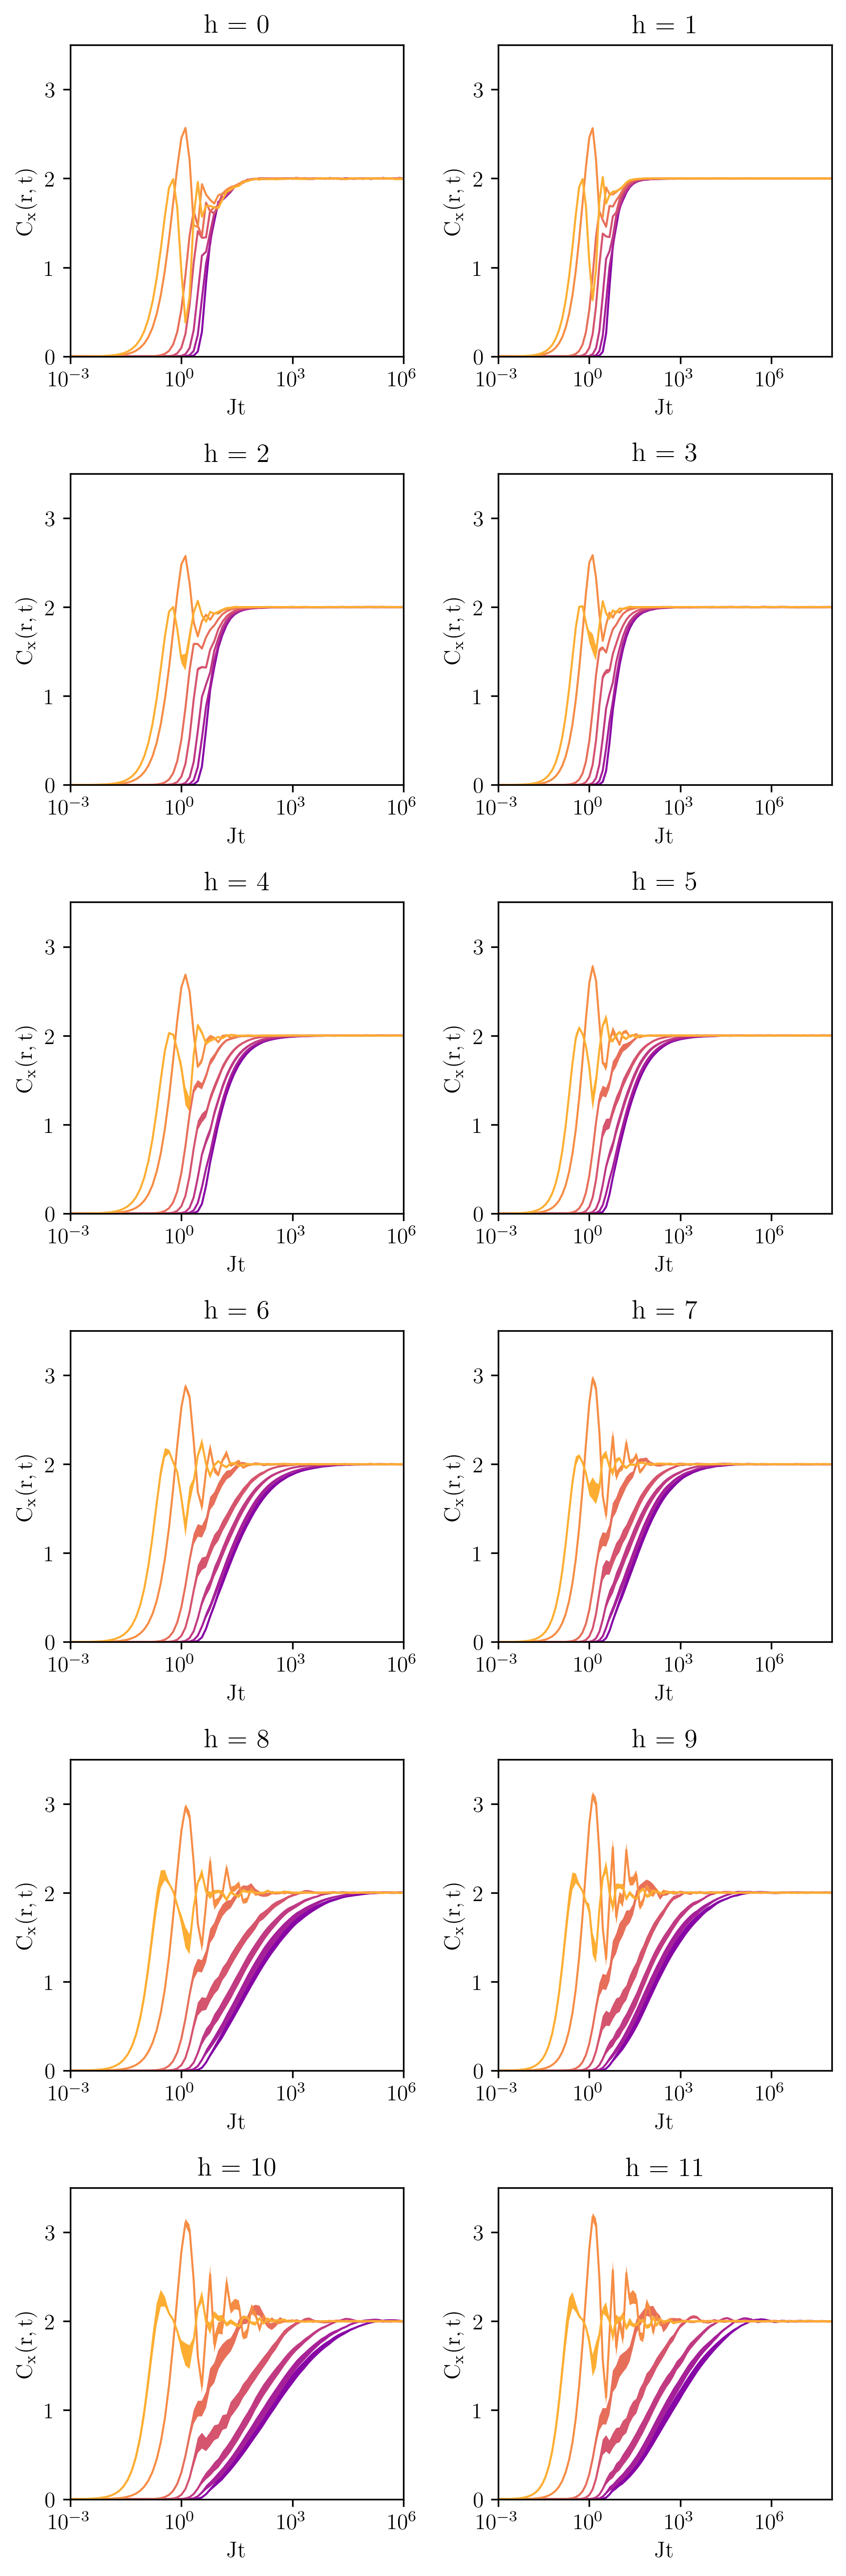

In [11]:
fig, axs = plt.subplots(6, 2,figsize=set_size(subplots=(6,2)),dpi = 300)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
for i in range(0,6):
    axs[i,0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
    axs[i,0].set_xscale("log")
    for j in range(0,N//2+1):
        axs[i,0].plot(T,red[2*i][:,j],label="r={}".format(rvals[j]),lw=1)
        axs[i,0].fill_between(T, red[2*i][:,j]-red_sem[2*i][:,j], red[2*i][:,j]+red_sem[2*i][:,j])

    axs[i,0].set_xlabel(r"Jt")
    axs[i,0].set_ylabel(r"$\mathrm{C_x(r,t)}$")
    axs[i,0].set_title("h = {:.0f}".format(hs[2*i]))
    axs[i,0].set_xlim(1e-3,1e6)
    axs[i,0].set_ylim(0,3.5)

    axs[i,1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
    axs[i,1].set_xscale("log")
    for j in range(0,N//2+1):
        axs[i,1].plot(T,red[2*i+1][:,j],label="r={}".format(rvals[j]),lw=1)
        axs[i,1].fill_between(T, red[2*i+1][:,j]-red_sem[2*i+1][:,j], red[2*i+1][:,j]+red_sem[2*i+1][:,j])


    axs[i,1].set_xlabel(r"Jt")
    axs[i,1].set_ylabel(r"$\mathrm{C_x(r,t)}$")
    axs[i,1].set_title("h = {:.0f}".format(hs[2*i+1]))
    axs[i,1].set_xlim(1e-3,1e8)
    axs[i,1].set_ylim(0,3.5)

#handles, labels = axs[i,0].get_legend_handles_labels()
#order = np.flip(np.arange(0,N//2+1,1))
#axs[i,0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")

plt.tight_layout()

# ZZ Gallery

In [12]:
res_zz = [disorder_mean(data_zz[i]) for i in range(len(data_zz))]
res_sem_zz = [disorder_sem(data_zz[i]) for i in range(len(data_zz))]
red_zz = list(map(symmetrize,res_zz))
red_sem_zz = list(map(symmetrize,res_sem_zz))

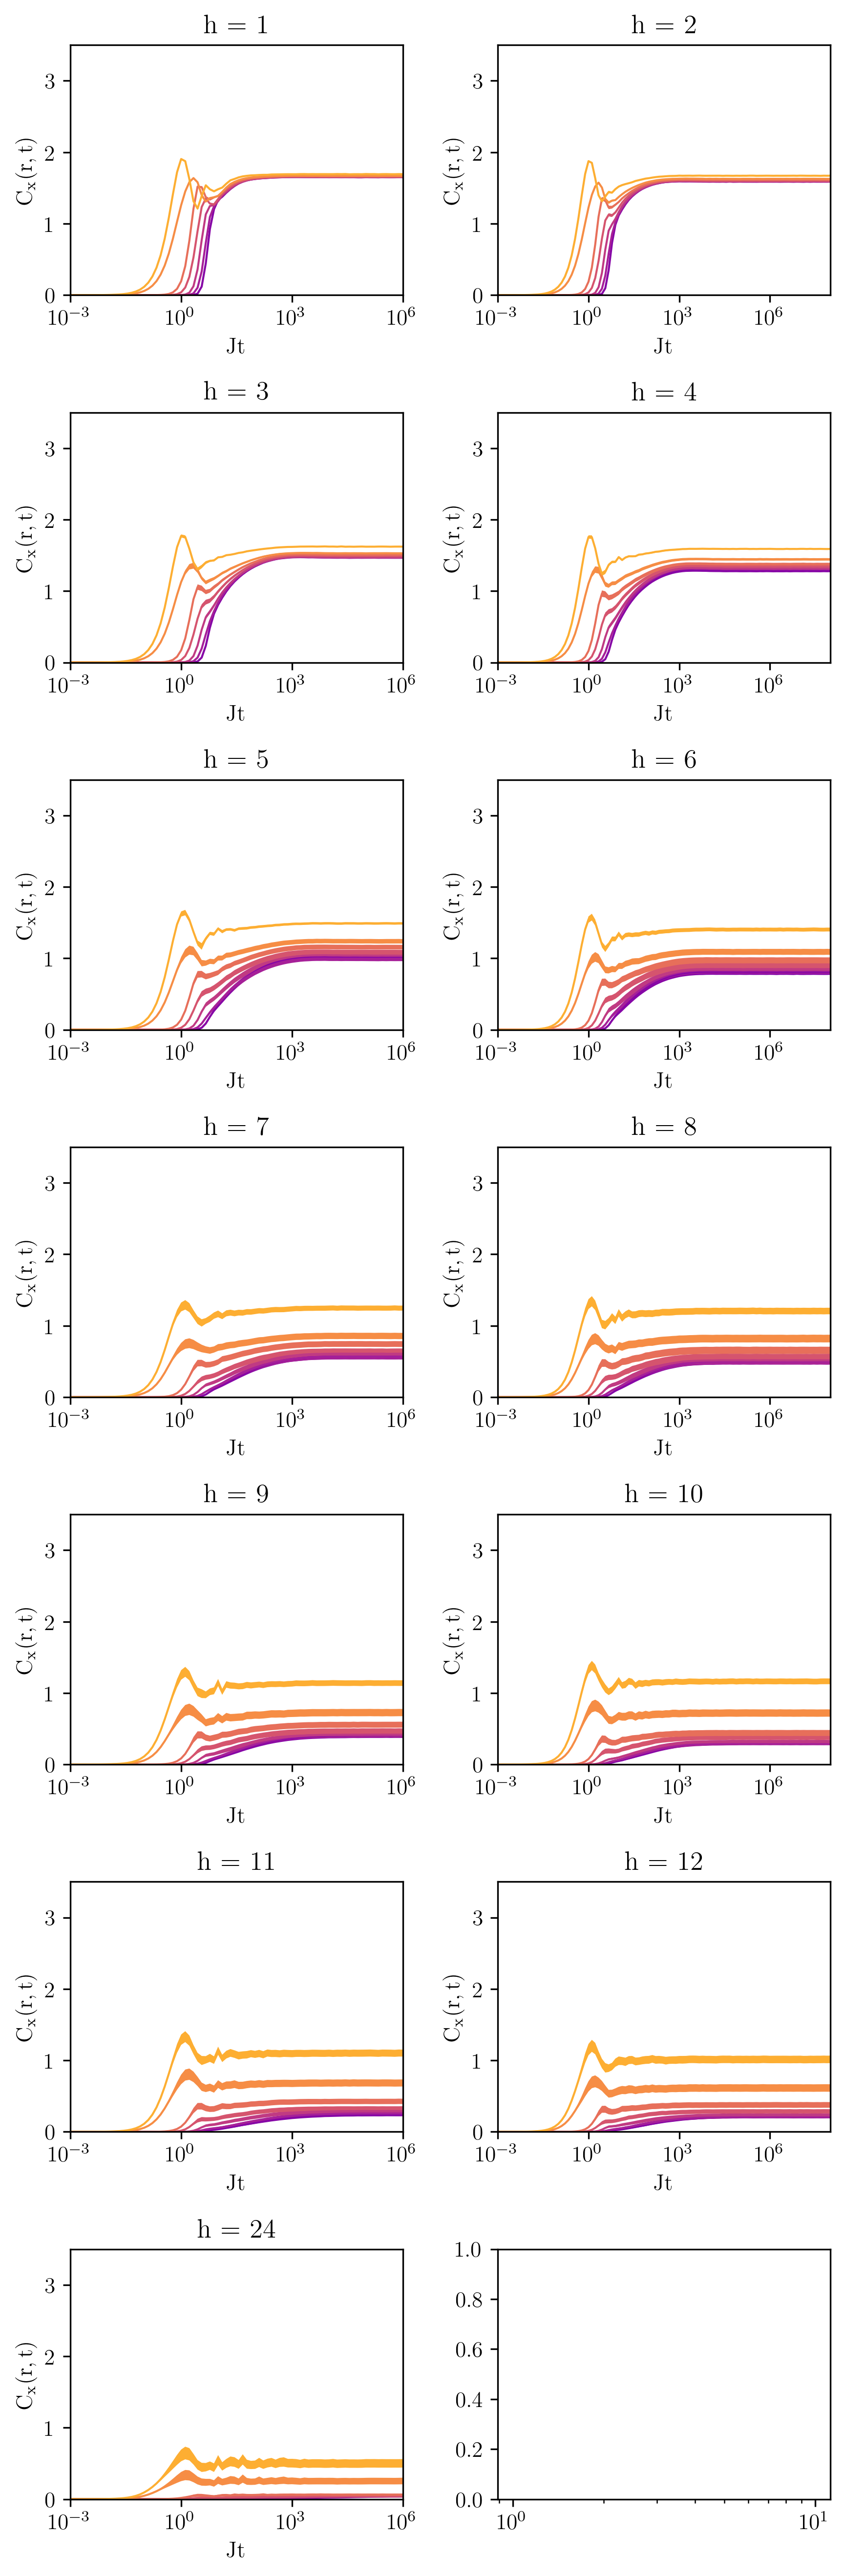

In [13]:
fig, axs = plt.subplots(7, 2,figsize=set_size(subplots=(6,2)),dpi = 300)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
for i in range(0,7):
    axs[i,0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
    axs[i,0].set_xscale("log")
    for j in range(0,N//2+1):
        axs[i,0].plot(T,red_zz[2*i][:,j],label="r={}".format(rvals[j]),lw=1)
        axs[i,0].fill_between(T, red_zz[2*i][:,j]-red_sem_zz[2*i][:,j], red_zz[2*i][:,j]+red_sem_zz[2*i][:,j])
        
    axs[i,0].set_xlabel(r"Jt")
    axs[i,0].set_ylabel(r"$\mathrm{C_x(r,t)}$")
    axs[i,0].set_title("h = {:.0f}".format(hs_z[2*i]))
    axs[i,0].set_xlim(1e-3,1e6)
    axs[i,0].set_ylim(0,3.5)

    axs[i,1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
    axs[i,1].set_xscale("log")
    if i <6:
        for j in range(0,N//2+1):
            axs[i,1].plot(T,red_zz[2*i+1][:,j],label="r={}".format(rvals[j]),lw=1)
            axs[i,1].fill_between(T, red_zz[2*i+1][:,j]-red_sem_zz[2*i+1][:,j], red_zz[2*i+1][:,j]+red_sem_zz[2*i+1][:,j])


        axs[i,1].set_xlabel(r"Jt")
        axs[i,1].set_ylabel(r"$\mathrm{C_x(r,t)}$")
        axs[i,1].set_title("h = {:.0f}".format(hs_z[2*i+1]))
        axs[i,1].set_xlim(1e-3,1e8)
        axs[i,1].set_ylim(0,3.5)

#handles, labels = axs[i,0].get_legend_handles_labels()
#order = np.flip(np.arange(0,N//2+1,1))
#axs[i,0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")

plt.tight_layout()

In [14]:
params_zz

[(13, 50, b'z', 1.),
 (13, 50, b'z', 2.),
 (13, 50, b'z', 3.),
 (13, 50, b'z', 4.),
 (13, 50, b'z', 5.),
 (13, 50, b'z', 6.),
 (13, 50, b'z', 7.),
 (13, 50, b'z', 8.),
 (13, 50, b'z', 9.),
 (13, 50, b'z', 10.),
 (13, 50, b'z', 11.),
 (13, 50, b'z', 12.),
 (13, 50, b'z', 24.)]

## ZZ NN Gallery

In [15]:
res_zz_nn = [disorder_mean(data_zz_nn[i]) for i in range(len(data_zz_nn))]
res_sem_zz_nn = [disorder_sem(data_zz_nn[i]) for i in range(len(data_zz_nn))]
red_zz_nn = list(map(symmetrize,res_zz_nn))
red_sem_zz_nn = list(map(symmetrize,res_sem_zz_nn))

IndexError: list index out of range

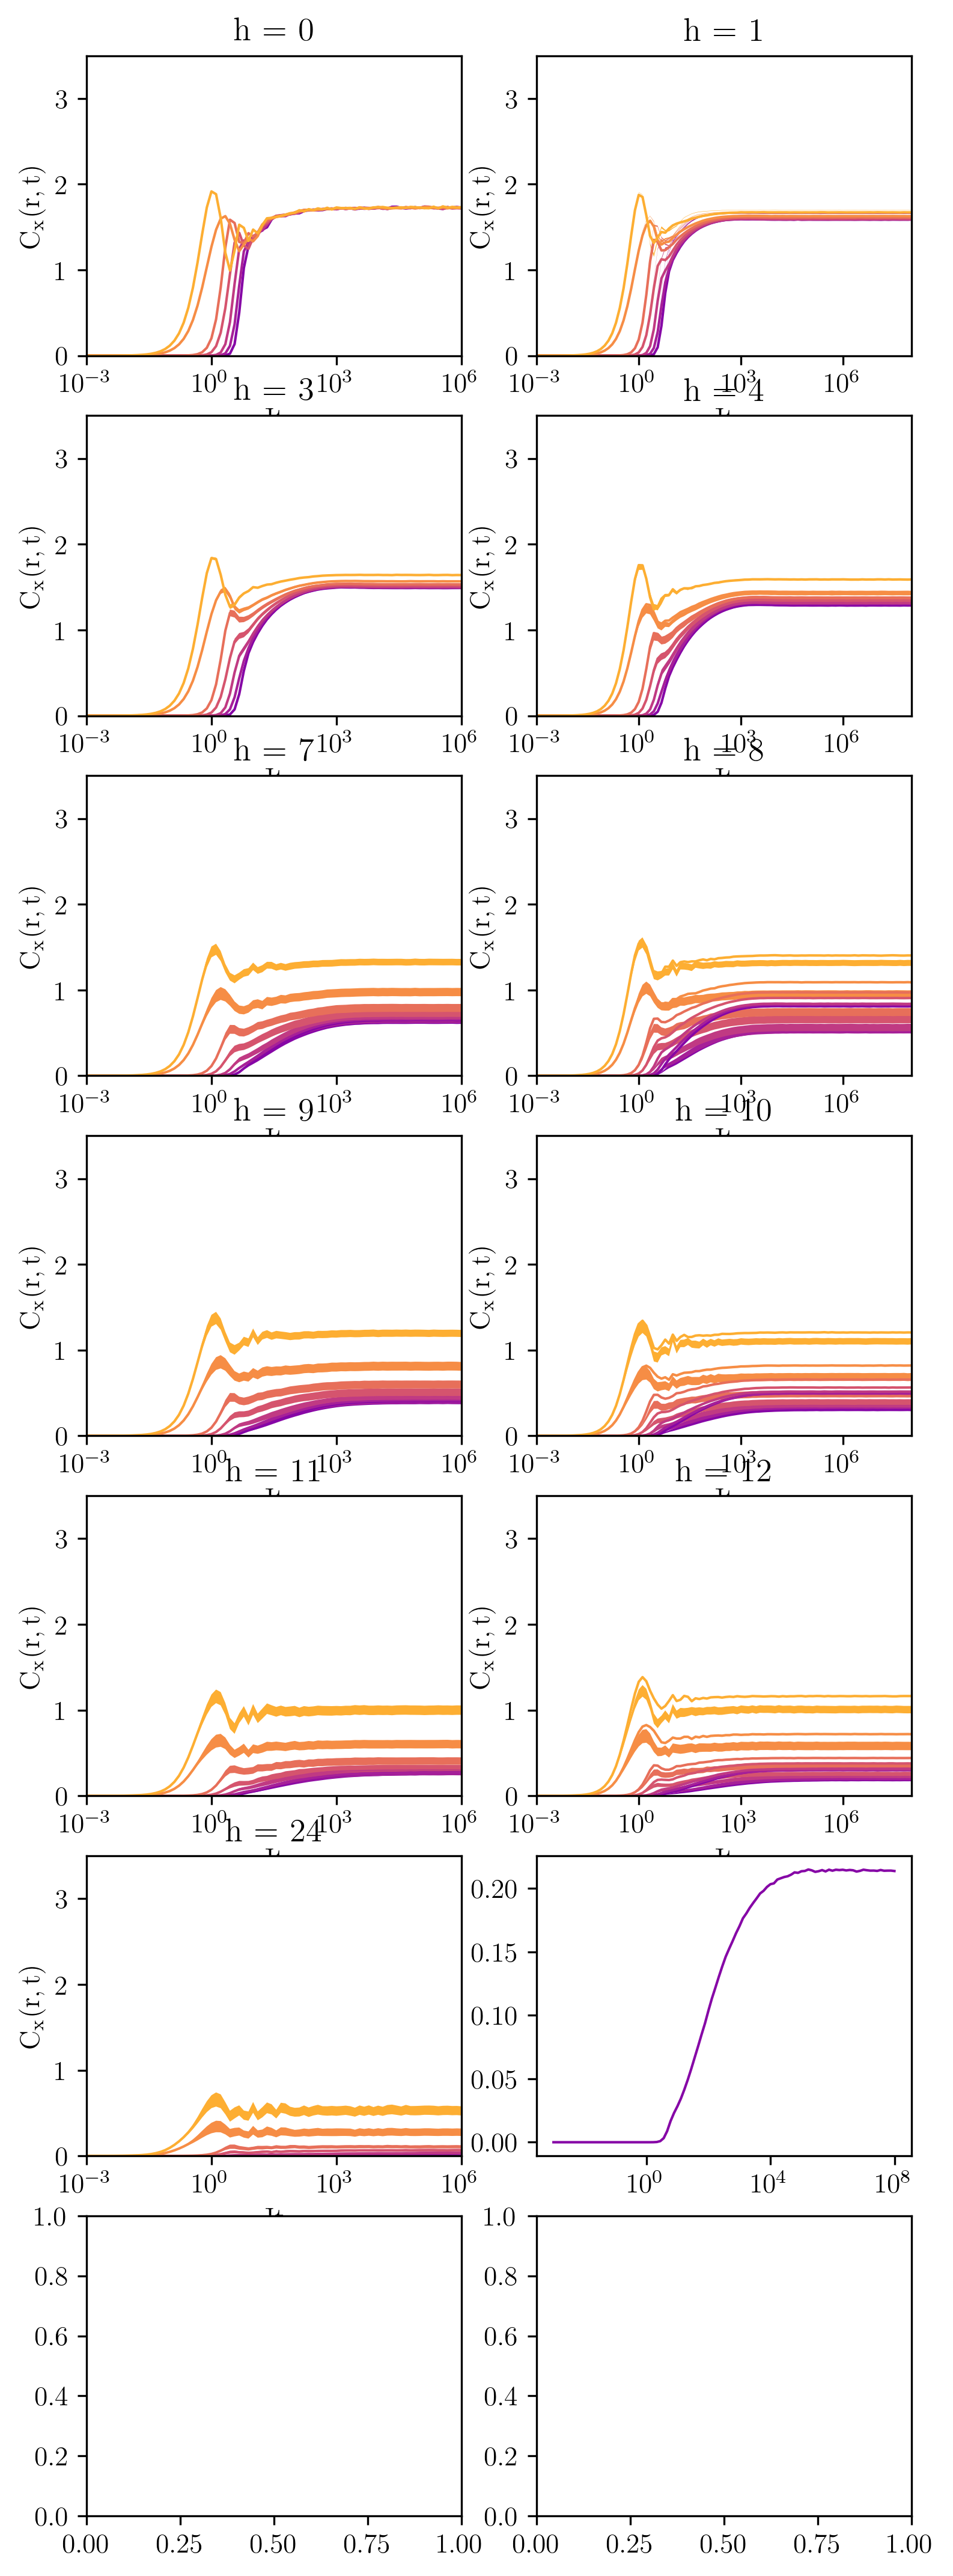

In [16]:
fig, axs = plt.subplots(7, 2,figsize=set_size(subplots=(6,2)),dpi = 300)

NUM_COLORS = 19//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
for i in range(0,6):
    axs[i,0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
    axs[i,0].set_xscale("log")
    for j in range(0,N//2+1):
        axs[i,0].plot(T,red_zz_nn[2*i][:,j],label="r={}".format(rvals[j]),lw=1)
        axs[i,0].fill_between(T, red_zz_nn[2*i][:,j]-red_sem_zz_nn[2*i][:,j], red_zz_nn[2*i][:,j]+red_sem_zz_nn[2*i][:,j])
        
    axs[i,0].set_xlabel(r"Jt")
    axs[i,0].set_ylabel(r"$\mathrm{C_x(r,t)}$")
    axs[i,0].set_title("h = {:.0f}".format(hs_z_nn[2*i]))
    axs[i,0].set_xlim(1e-3,1e6)
    axs[i,0].set_ylim(0,3.5)

    axs[i,1].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
    axs[i,1].set_xscale("log")
    if i <6:
        for j in range(0,N//2+1):
            axs[i,1].plot(T,red_zz[2*i+1][:,j],label="r={}".format(rvals[j]),lw=1)
            axs[i,1].fill_between(T, red_zz_nn[2*i+1][:,j]-red_sem_zz_nn[2*i+1][:,j], red_zz_nn[2*i+1][:,j]+red_sem_zz_nn[2*i+1][:,j])


        axs[i,1].set_xlabel(r"Jt")
        axs[i,1].set_ylabel(r"$\mathrm{C_x(r,t)}$")
        axs[i,1].set_title("h = {:.0f}".format(hs_z_nn[2*i+1]))
        axs[i,1].set_xlim(1e-3,1e8)
        axs[i,1].set_ylim(0,3.5)

#handles, labels = axs[i,0].get_legend_handles_labels()
#order = np.flip(np.arange(0,N//2+1,1))
#axs[i,0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right")

plt.tight_layout()

In [105]:
len(red_zz)

13

(0.001, 1)

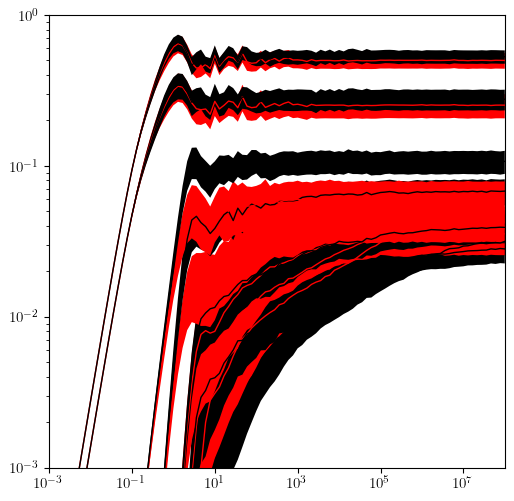

In [119]:
for j in range(0,N//2+1):
    plt.plot(T,red_zz[-1][:,j],label="r={}".format(rvals[j]),lw=1,c="red")
    plt.fill_between(T, red_zz[-1][:,j]-red_sem_zz[-1][:,j], red_zz[-1][:,j]+red_sem_zz[-1][:,j],fc="red")

    plt.plot(T,red_zz_nn[-1][:,j],label="r={}".format(rvals[j]),lw=1,c="black")
    plt.fill_between(T, red_zz_nn[-1][:,j]-red_sem_zz_nn[-1][:,j], red_zz_nn[-1][:,j]+red_sem_zz_nn[-1][:,j],fc="black")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-3,1e8)
plt.ylim(1e-3,1)

In [130]:
np.mean(red_zz[-2][66:],axis=0)

array([0.21349278, 0.21210561, 0.23077819, 0.28610846, 0.37603506,
       0.61309472, 1.01259261])

In [132]:
np.mean(red_sem_zz[-2][66:],axis=0)

array([0.02183841, 0.02495091, 0.02594607, 0.03026857, 0.03976411,
       0.05233965, 0.05254848])

In [131]:
np.mean(red_zz_nn[-2][66:],axis=0)

array([0.18913622, 0.20060977, 0.22798679, 0.25665856, 0.33974642,
       0.58187581, 1.00703213])

In [133]:
np.mean(red_sem_zz_nn[-2][66:],axis=0)

array([0.02146406, 0.02177844, 0.02270152, 0.02412207, 0.03197693,
       0.04898187, 0.04334461])

In [20]:
params_zz

[(13, 50, b'z', 1.),
 (13, 50, b'z', 2.),
 (13, 50, b'z', 3.),
 (13, 50, b'z', 4.),
 (13, 50, b'z', 5.),
 (13, 50, b'z', 6.),
 (13, 50, b'z', 7.),
 (13, 50, b'z', 8.),
 (13, 50, b'z', 9.),
 (13, 50, b'z', 10.),
 (13, 50, b'z', 11.),
 (13, 50, b'z', 12.),
 (13, 50, b'z', 24.)]

In [21]:
params_zz_nn

[(13, 25, b'z', 0.),
 (13, 50, b'z', 1.),
 (13, 50, b'z', 3.),
 (13, 50, b'z', 4.),
 (13, 50, b'z', 7.),
 (13, 50, b'z', 8.),
 (13, 50, b'z', 9.),
 (13, 50, b'z', 10.),
 (13, 50, b'z', 11.),
 (13, 50, b'z', 12.),
 (13, 50, b'z', 24.)]

In [34]:
ltv = np.zeros((len(red_zz),N//2+1))
ltv_err = np.zeros((len(red_zz),N//2+1))

ltv_nn = np.zeros((len(red_zz),N//2+1))
for i in range(len(red_zz)):
    ltv[i] = np.mean(red_zz[i][66:,:],axis=0)
    ltv_err[i] = np.mean(red_sem_zz[i][66:],axis=0)

for i in range(len(red_zz_nn)):
    ltv_nn[i] = np.mean(red_zz_nn[i][66:,:],axis=0)

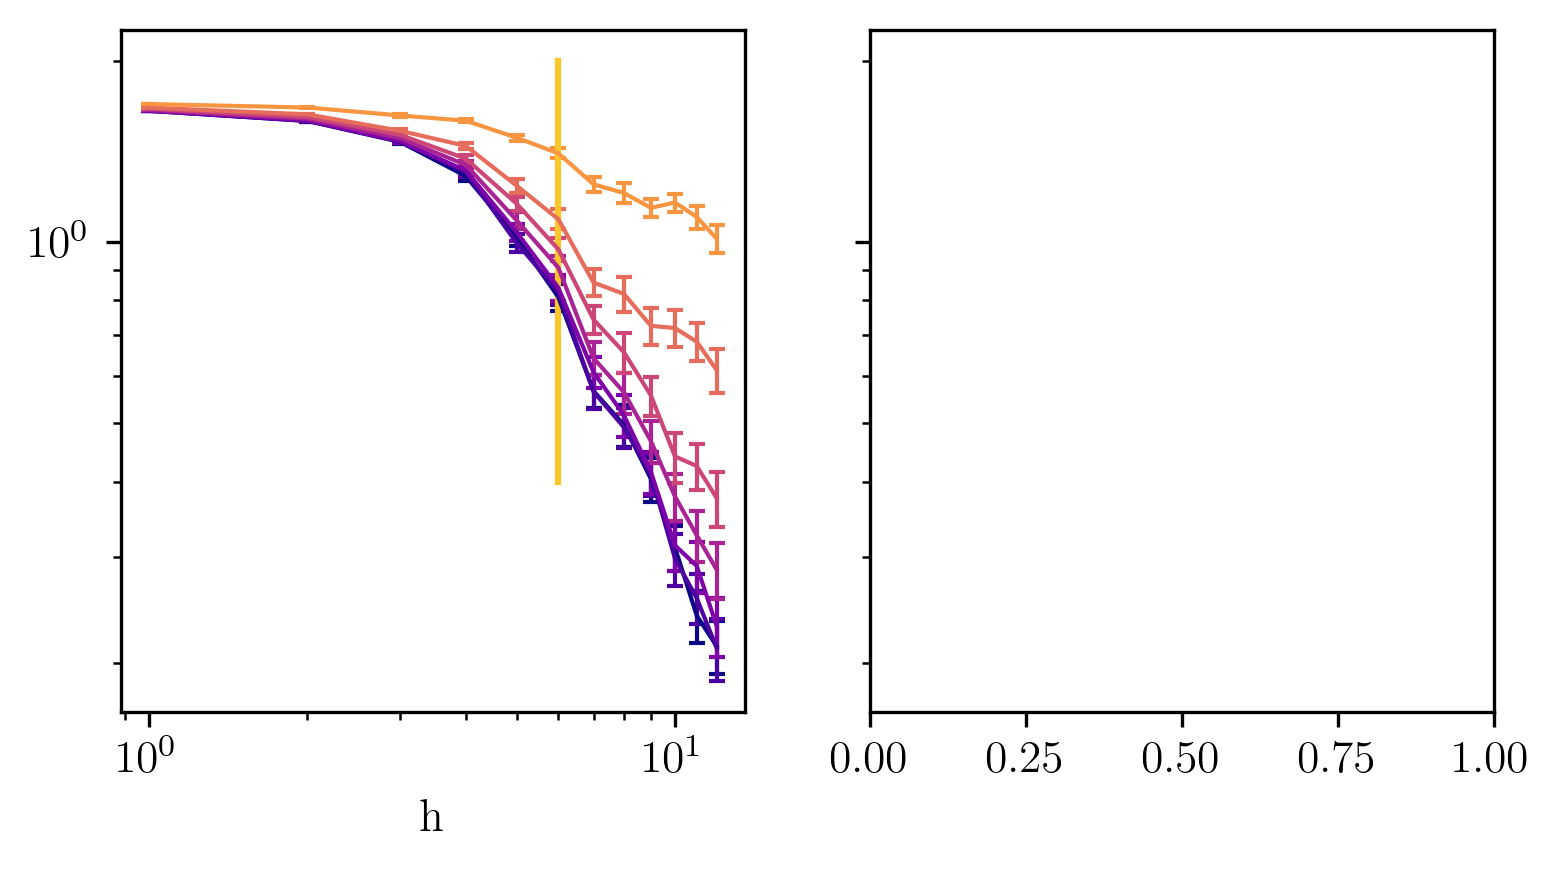

In [37]:
fig, axs = plt.subplots(1,2,figsize=set_size(subplots=(1,2)),dpi = 300,sharey=True)

NUM_COLORS = 13//2+2 #11
cm = plt.get_cmap('plasma')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)


axs[0].set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(NUM_COLORS-N//2-2,NUM_COLORS)])
#axs[0].set_xscale("log")
for j in range(0,N//2+1):
    #axs[0].plot(hs_z[:-1],ltv[:-1,j],label="r={}".format(rvals[j]),lw=1,marker="+")
    axs[0].errorbar(hs_z[:-1],ltv[:-1,j],yerr=ltv_err[:-1,j],label="r={}".format(rvals[j]),lw=1,capsize=2)
    #axs[0,0].plot(T,red_nn[0][:,j],ls="dotted",c="black",lw=1)

    #axs[0,0].fill_between(T, red[0][:,j]-red_sem[0][:,j], red[0][:,j]+red_sem[0][:,j])
    #axs[0,0].fill_between(T, red_nn[0][:,j]-red_sem_nn[0][:,j], red_nn[0][:,j]+red_sem_nn[0][:,j],fc="black")


axs[0].plot([6,6],[4e-1,2])

handles, labels = axs[0].get_legend_handles_labels()
order = np.flip(np.arange(0,N//2+1,1))
#axs[0].legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc="lower right",fontsize = "x-small")

axs[0].set_xlabel("h")
axs[0].set_yscale("log")
axs[0].set_xscale("log")